### Importing Libraries

In [32]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Add, Flatten, MaxPool2D

### Constants

In [33]:
batch_size = 32
num_classes = 124
tf.random.set_seed(42)
img_height, img_width = 128, 128
data_dir = os.path.join(os.getcwd(), "../5-Gait-Energy-Images")

### Training Data Augmentation

In [34]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rescale=1.0 / 255,
    rotation_range=20,
    fill_mode="nearest",
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    width_shift_range=0.2,
    validation_split=0.15,
    height_shift_range=0.2,
    channel_shift_range=10,
    brightness_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [35]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [36]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=True,
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=False,
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

Found 11587 images belonging to 124 classes.
Found 1974 images belonging to 124 classes.


### ResNet18 Model

In [37]:
class ResnetBlock(Model):
    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

### Create the model

In [38]:
model = ResNet18(124)
model.build(input_shape =(None, 128,128,1))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Define Top k Accuracy Function

In [39]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Compile the model

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', top_5_accuracy])

### Define the Callbacks

In [41]:
checkpoint = ModelCheckpoint(
    "best_model.x", monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_acc', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=5, min_lr=1e-7)

### Train the model

In [42]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=500,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    use_multiprocessing=True)

Epoch 1/500
363/363 [==============================] - ETA: 0s - loss: 4.6731 - acc: 0.0320 - top_5_accuracy: 0.1152INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 109s 280ms/step - loss: 4.6731 - acc: 0.0320 - top_5_accuracy: 0.1152 - val_loss: 7.1313 - val_acc: 0.0193 - val_top_5_accuracy: 0.0755 - lr: 0.0010
Epoch 2/500
363/363 [==============================] - ETA: 0s - loss: 4.0108 - acc: 0.0810 - top_5_accuracy: 0.2541INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 268ms/step - loss: 4.0108 - acc: 0.0810 - top_5_accuracy: 0.2541 - val_loss: 4.9959 - val_acc: 0.0572 - val_top_5_accuracy: 0.1935 - lr: 0.0010
Epoch 3/500
363/363 [==============================] - ETA: 0s - loss: 3.6251 - acc: 0.1276 - top_5_accuracy: 0.3588INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 264ms/step - loss: 3.6251 - acc: 0.1276 - top_5_accuracy: 0.3588 - val_loss: 3.8379 - val_acc: 0.1165 - val_top_5_accuracy: 0.3485 - lr: 0.0010
Epoch 4/500
363/363 [==============================] - 89s 242ms/step - loss: 3.2959 - acc: 0.1812 - top_5_accuracy: 0.4457 - val_loss: 7.0338 - val_acc: 0.0395 - val_top_5_accuracy: 0.1206 - lr: 0.0010
Epoch 5/500
363/363 [==============================] - ETA: 0s - loss: 2.9871 - acc: 0.2305 - top_5_accuracy: 0.5320INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 265ms/step - loss: 2.9871 - acc: 0.2305 - top_5_accuracy: 0.5320 - val_loss: 3.7468 - val_acc: 0.1727 - val_top_5_accuracy: 0.3982 - lr: 0.0010
Epoch 6/500
363/363 [==============================] - 88s 240ms/step - loss: 2.7004 - acc: 0.2837 - top_5_accuracy: 0.6041 - val_loss: 8.1586 - val_acc: 0.0542 - val_top_5_accuracy: 0.1530 - lr: 0.0010
Epoch 7/500
363/363 [==============================] - ETA: 0s - loss: 2.4273 - acc: 0.3456 - top_5_accuracy: 0.6703INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 96s 262ms/step - loss: 2.4273 - acc: 0.3456 - top_5_accuracy: 0.6703 - val_loss: 3.3966 - val_acc: 0.2163 - val_top_5_accuracy: 0.4737 - lr: 0.0010
Epoch 8/500
363/363 [==============================] - ETA: 0s - loss: 2.1841 - acc: 0.3910 - top_5_accuracy: 0.7314INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 96s 263ms/step - loss: 2.1841 - acc: 0.3910 - top_5_accuracy: 0.7314 - val_loss: 3.0897 - val_acc: 0.2584 - val_top_5_accuracy: 0.5537 - lr: 0.0010
Epoch 9/500
363/363 [==============================] - ETA: 0s - loss: 1.9868 - acc: 0.4448 - top_5_accuracy: 0.7715INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 266ms/step - loss: 1.9868 - acc: 0.4448 - top_5_accuracy: 0.7715 - val_loss: 3.0048 - val_acc: 0.2969 - val_top_5_accuracy: 0.6353 - lr: 0.0010
Epoch 10/500
363/363 [==============================] - ETA: 0s - loss: 1.7891 - acc: 0.4902 - top_5_accuracy: 0.8058INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 265ms/step - loss: 1.7891 - acc: 0.4902 - top_5_accuracy: 0.8058 - val_loss: 3.0540 - val_acc: 0.3207 - val_top_5_accuracy: 0.5922 - lr: 0.0010
Epoch 11/500
363/363 [==============================] - ETA: 0s - loss: 1.6030 - acc: 0.5361 - top_5_accuracy: 0.8443INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 265ms/step - loss: 1.6030 - acc: 0.5361 - top_5_accuracy: 0.8443 - val_loss: 2.4760 - val_acc: 0.3632 - val_top_5_accuracy: 0.6945 - lr: 0.0010
Epoch 12/500
363/363 [==============================] - 88s 242ms/step - loss: 1.4575 - acc: 0.5703 - top_5_accuracy: 0.8724 - val_loss: 9.5519 - val_acc: 0.0770 - val_top_5_accuracy: 0.1748 - lr: 0.0010
Epoch 13/500
363/363 [==============================] - 88s 241ms/step - loss: 1.3380 - acc: 0.6074 - top_5_accuracy: 0.8872 - val_loss: 5.7029 - val_acc: 0.1727 - val_top_5_accuracy: 0.4549 - lr: 0.0010
Epoch 14/500
363/363 [==============================] - 89s 242ms/step - loss: 1.2022 - acc: 0.6405 - top_5_accuracy: 0.9046 - val_loss: 3.3794 - val_acc: 0.2908 - val_top_5_accuracy: 0.5947 - lr: 0.0010
Epoch 15/500
363/363 [==============================] - ETA: 0s - loss: 1.1258 - acc: 0.6638 - top_5_accuracy: 0.9152INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 267ms/step - loss: 1.1258 - acc: 0.6638 - top_5_accuracy: 0.9152 - val_loss: 3.0530 - val_acc: 0.3708 - val_top_5_accuracy: 0.6636 - lr: 0.0010
Epoch 16/500
363/363 [==============================] - 89s 243ms/step - loss: 1.0141 - acc: 0.6944 - top_5_accuracy: 0.9311 - val_loss: 3.8178 - val_acc: 0.3065 - val_top_5_accuracy: 0.5968 - lr: 0.0010
Epoch 17/500
363/363 [==============================] - ETA: 0s - loss: 0.9295 - acc: 0.7149 - top_5_accuracy: 0.9411INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 266ms/step - loss: 0.9295 - acc: 0.7149 - top_5_accuracy: 0.9411 - val_loss: 2.6713 - val_acc: 0.4149 - val_top_5_accuracy: 0.7543 - lr: 0.0010
Epoch 18/500
363/363 [==============================] - ETA: 0s - loss: 0.8681 - acc: 0.7356 - top_5_accuracy: 0.9479INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 265ms/step - loss: 0.8681 - acc: 0.7356 - top_5_accuracy: 0.9479 - val_loss: 1.4576 - val_acc: 0.5988 - val_top_5_accuracy: 0.8850 - lr: 0.0010
Epoch 19/500
363/363 [==============================] - 89s 244ms/step - loss: 0.8219 - acc: 0.7435 - top_5_accuracy: 0.9534 - val_loss: 6.8264 - val_acc: 0.1651 - val_top_5_accuracy: 0.3501 - lr: 0.0010
Epoch 20/500
363/363 [==============================] - 88s 240ms/step - loss: 0.7400 - acc: 0.7718 - top_5_accuracy: 0.9614 - val_loss: 2.6433 - val_acc: 0.4448 - val_top_5_accuracy: 0.7584 - lr: 0.0010
Epoch 21/500
363/363 [==============================] - 89s 242ms/step - loss: 0.6943 - acc: 0.7863 - top_5_accuracy: 0.9680 - val_loss: 2.7314 - val_acc: 0.3779 - val_top_5_accuracy: 0.7406 - lr: 0.0010
Epoch 22/500
363/363 [==============================] - 89s 243ms/step - loss: 0.6670 - acc: 0.7880 - top_5_accuracy: 0.9705 - val_loss: 3.8432 - val_acc: 0.3678 - val_top_5_accuracy: 0.6707 - lr: 

INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 268ms/step - loss: 0.3865 - acc: 0.8811 - top_5_accuracy: 0.9885 - val_loss: 1.1069 - val_acc: 0.6940 - val_top_5_accuracy: 0.9225 - lr: 1.0000e-04
Epoch 25/500
363/363 [==============================] - ETA: 0s - loss: 0.3087 - acc: 0.9121 - top_5_accuracy: 0.9921INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 268ms/step - loss: 0.3087 - acc: 0.9121 - top_5_accuracy: 0.9921 - val_loss: 0.9180 - val_acc: 0.7548 - val_top_5_accuracy: 0.9367 - lr: 1.0000e-04
Epoch 26/500
363/363 [==============================] - 88s 242ms/step - loss: 0.2848 - acc: 0.9179 - top_5_accuracy: 0.9935 - val_loss: 0.9020 - val_acc: 0.7528 - val_top_5_accuracy: 0.9433 - lr: 1.0000e-04
Epoch 27/500
363/363 [==============================] - 90s 245ms/step - loss: 0.2681 - acc: 0.9208 - top_5_accuracy: 0.9939 - val_loss: 1.7635 - val_acc: 0.5841 - val_top_5_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 28/500
363/363 [==============================] - ETA: 0s - loss: 0.2429 - acc: 0.9318 - top_5_accuracy: 0.9956INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 267ms/step - loss: 0.2429 - acc: 0.9318 - top_5_accuracy: 0.9956 - val_loss: 0.8217 - val_acc: 0.7801 - val_top_5_accuracy: 0.9519 - lr: 1.0000e-04
Epoch 29/500
363/363 [==============================] - 89s 242ms/step - loss: 0.2382 - acc: 0.9337 - top_5_accuracy: 0.9950 - val_loss: 1.1336 - val_acc: 0.7118 - val_top_5_accuracy: 0.9174 - lr: 1.0000e-04
Epoch 30/500
363/363 [==============================] - 89s 243ms/step - loss: 0.2338 - acc: 0.9310 - top_5_accuracy: 0.9957 - val_loss: 0.8118 - val_acc: 0.7796 - val_top_5_accuracy: 0.9534 - lr: 1.0000e-04
Epoch 31/500
363/363 [==============================] - 89s 243ms/step - loss: 0.2267 - acc: 0.9340 - top_5_accuracy: 0.9954 - val_loss: 1.9174 - val_acc: 0.5578 - val_top_5_accuracy: 0.8384 - lr: 1.0000e-04
Epoch 32/500
363/363 [==============================] - ETA: 0s - loss: 0.2120 - acc: 0.9380 - top_5_accuracy: 0.9953INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 102s 277ms/step - loss: 0.2120 - acc: 0.9380 - top_5_accuracy: 0.9953 - val_loss: 0.7882 - val_acc: 0.7893 - val_top_5_accuracy: 0.9569 - lr: 1.0000e-04
Epoch 33/500
363/363 [==============================] - 89s 243ms/step - loss: 0.2104 - acc: 0.9382 - top_5_accuracy: 0.9950 - val_loss: 1.0674 - val_acc: 0.7259 - val_top_5_accuracy: 0.9286 - lr: 1.0000e-04
Epoch 34/500
363/363 [==============================] - ETA: 0s - loss: 0.1996 - acc: 0.9445 - top_5_accuracy: 0.9973INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 269ms/step - loss: 0.1996 - acc: 0.9445 - top_5_accuracy: 0.9973 - val_loss: 0.7551 - val_acc: 0.7994 - val_top_5_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 35/500
363/363 [==============================] - ETA: 0s - loss: 0.1963 - acc: 0.9457 - top_5_accuracy: 0.9967INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 267ms/step - loss: 0.1963 - acc: 0.9457 - top_5_accuracy: 0.9967 - val_loss: 0.7287 - val_acc: 0.7999 - val_top_5_accuracy: 0.9595 - lr: 1.0000e-04
Epoch 36/500
363/363 [==============================] - ETA: 0s - loss: 0.1866 - acc: 0.9455 - top_5_accuracy: 0.9975INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 97s 267ms/step - loss: 0.1866 - acc: 0.9455 - top_5_accuracy: 0.9975 - val_loss: 0.7594 - val_acc: 0.8004 - val_top_5_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 37/500
363/363 [==============================] - 89s 244ms/step - loss: 0.1828 - acc: 0.9477 - top_5_accuracy: 0.9972 - val_loss: 0.7663 - val_acc: 0.7964 - val_top_5_accuracy: 0.9580 - lr: 1.0000e-04
Epoch 38/500
363/363 [==============================] - 88s 241ms/step - loss: 0.1789 - acc: 0.9502 - top_5_accuracy: 0.9970 - val_loss: 0.8005 - val_acc: 0.7877 - val_top_5_accuracy: 0.9519 - lr: 1.0000e-04
Epoch 39/500
363/363 [==============================] - ETA: 0s - loss: 0.1744 - acc: 0.9484 - top_5_accuracy: 0.9972INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 267ms/step - loss: 0.1744 - acc: 0.9484 - top_5_accuracy: 0.9972 - val_loss: 0.7543 - val_acc: 0.8040 - val_top_5_accuracy: 0.9580 - lr: 1.0000e-04
Epoch 40/500
363/363 [==============================] - ETA: 0s - loss: 0.1627 - acc: 0.9526 - top_5_accuracy: 0.9972INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 268ms/step - loss: 0.1627 - acc: 0.9526 - top_5_accuracy: 0.9972 - val_loss: 0.7545 - val_acc: 0.8121 - val_top_5_accuracy: 0.9585 - lr: 1.0000e-04
Epoch 41/500
363/363 [==============================] - 90s 246ms/step - loss: 0.1579 - acc: 0.9541 - top_5_accuracy: 0.9974 - val_loss: 1.0362 - val_acc: 0.7361 - val_top_5_accuracy: 0.9372 - lr: 1.0000e-04
Epoch 42/500
363/363 [==============================] - 90s 244ms/step - loss: 0.1593 - acc: 0.9555 - top_5_accuracy: 0.9981 - val_loss: 0.9695 - val_acc: 0.7477 - val_top_5_accuracy: 0.9367 - lr: 1.0000e-04
Epoch 43/500
363/363 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.9546 - top_5_accuracy: 0.9983INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 99s 271ms/step - loss: 0.1560 - acc: 0.9546 - top_5_accuracy: 0.9983 - val_loss: 0.7158 - val_acc: 0.8151 - val_top_5_accuracy: 0.9645 - lr: 1.0000e-04
Epoch 44/500
363/363 [==============================] - 89s 244ms/step - loss: 0.1466 - acc: 0.9578 - top_5_accuracy: 0.9979 - val_loss: 0.7302 - val_acc: 0.8060 - val_top_5_accuracy: 0.9640 - lr: 1.0000e-04
Epoch 45/500
363/363 [==============================] - 88s 242ms/step - loss: 0.1528 - acc: 0.9563 - top_5_accuracy: 0.9973 - val_loss: 0.7391 - val_acc: 0.8095 - val_top_5_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 46/500
363/363 [==============================] - ETA: 0s - loss: 0.1505 - acc: 0.9570 - top_5_accuracy: 0.9978INFO:tensorflow:Assets written to: best_model.x/assets


INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 268ms/step - loss: 0.1505 - acc: 0.9570 - top_5_accuracy: 0.9978 - val_loss: 0.7030 - val_acc: 0.8156 - val_top_5_accuracy: 0.9666 - lr: 1.0000e-04
Epoch 47/500
363/363 [==============================] - 89s 243ms/step - loss: 0.1479 - acc: 0.9562 - top_5_accuracy: 0.9980 - val_loss: 0.7755 - val_acc: 0.8045 - val_top_5_accuracy: 0.9574 - lr: 1.0000e-04
Epoch 48/500
363/363 [==============================] - 89s 243ms/step - loss: 0.1474 - acc: 0.9575 - top_5_accuracy: 0.9986 - val_loss: 0.8870 - val_acc: 0.7766 - val_top_5_accuracy: 0.9438 - lr: 1.0000e-04
Epoch 49/500
363/363 [==============================] - 89s 242ms/step - loss: 0.1337 - acc: 0.9634 - top_5_accuracy: 0.9980 - val_loss: 0.9913 - val_acc: 0.7477 - val_top_5_accuracy: 0.9367 - lr: 1.0000e-04
Epoch 50/500
363/363 [==============================] - 89s 243ms/step - loss: 0.1390 - acc: 0.9592 - top_5_accuracy: 0.9980 - val_loss: 0.8152 - val_acc: 0.7958 - val_top_5_accurac

INFO:tensorflow:Assets written to: best_model.x/assets


363/363 [==============================] - 98s 267ms/step - loss: 0.1378 - acc: 0.9587 - top_5_accuracy: 0.9982 - val_loss: 0.6640 - val_acc: 0.8278 - val_top_5_accuracy: 0.9650 - lr: 1.0000e-04
Epoch 52/500
363/363 [==============================] - 89s 243ms/step - loss: 0.1374 - acc: 0.9621 - top_5_accuracy: 0.9979 - val_loss: 1.3260 - val_acc: 0.6717 - val_top_5_accuracy: 0.9083 - lr: 1.0000e-04
Epoch 53/500
363/363 [==============================] - 89s 244ms/step - loss: 0.1313 - acc: 0.9627 - top_5_accuracy: 0.9976 - val_loss: 2.0789 - val_acc: 0.5360 - val_top_5_accuracy: 0.8328 - lr: 1.0000e-04
Epoch 54/500
363/363 [==============================] - 90s 246ms/step - loss: 0.1228 - acc: 0.9648 - top_5_accuracy: 0.9989 - val_loss: 0.6785 - val_acc: 0.8227 - val_top_5_accuracy: 0.9650 - lr: 1.0000e-04
Epoch 55/500
363/363 [==============================] - 90s 244ms/step - loss: 0.1210 - acc: 0.9656 - top_5_accuracy: 0.9983 - val_loss: 0.9403 - val_acc: 0.7548 - val_top_5_accurac

### Evaluate model on training set

In [43]:
train_loss, train_accuracy, top5train = model.evaluate(train_generator)
print(f"Training Loss: {round(train_loss, 2)}")
print(f"Training Accuracy: {round(train_accuracy, 2)}")
print(f"Training Top 5 Accuracy: {round(top5train, 2)}")

363/363 [==============================] - 43s 119ms/step - loss: 0.1278 - acc: 0.9612 - top_5_accuracy: 0.9980
Training Loss: 0.13
Training Accuracy: 0.96
Training Top 5 Accuracy: 1.0


### Evaluate model on testing set

In [44]:
test_loss, test_accuracy, top5test = model.evaluate(test_generator)
print(f"Testing Loss: {round(test_loss, 2)}")
print(f"Testing Accuracy: {round(test_accuracy, 2)}")
print(f"Testing Top 5 Accuracy: {round(top5test, 2)}")

62/62 [==============================] - 5s 71ms/step - loss: 0.6640 - acc: 0.8278 - top_5_accuracy: 0.9650
Testing Loss: 0.66
Testing Accuracy: 0.83
Testing Top 5 Accuracy: 0.97


### Save the model

In [50]:
model.save('../10-Trained-Models/ResNet18.keras')

### Model Summary

In [46]:
model.summary()

Model: "res_net18_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          multiple                  3200      
                                                                 
 batch_normalization_40 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet_block_16 (ResnetBlo  multiple                  74368     
 ck)                                                             
                                                                 
 resnet_block_17 (ResnetBlo  multiple                  74368     
 ck)                                                   

### Plot Training & Validation Accuracy

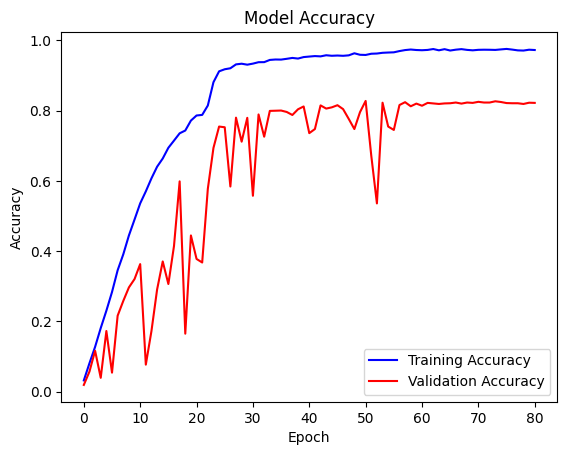

In [47]:
plt.plot(history.history['acc'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_acc'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

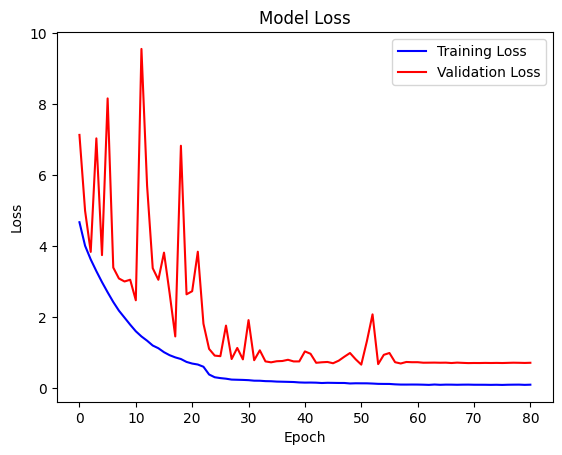

In [48]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Training and Testing Top 5 Accuracy

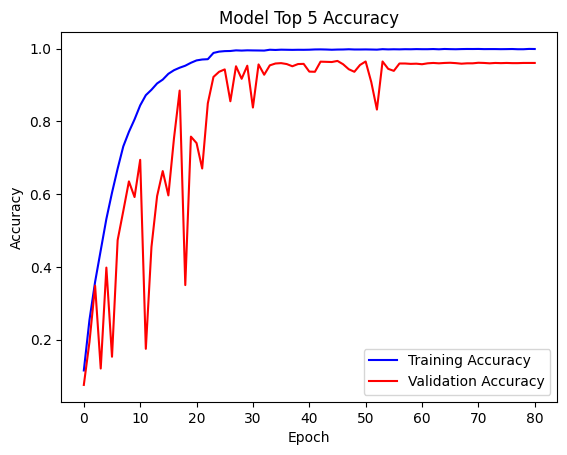

In [49]:
plt.plot(history.history['top_5_accuracy'],
         color='blue', label='Training Accuracy')
plt.plot(history.history['val_top_5_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Top 5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()